In [1]:
import csv
from typing import Optional,Any
import random
import arrow
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Sequential
#from keras.src.layers import LSTM, Dropout, Dense
from pandas import DatetimeIndex
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# 可视化结果（如果需要）
import matplotlib.pyplot as plt
import os
import pathlib
import xml.etree.ElementTree as ET
import xarray as xr
import codecs
import datetime

# 先从海浪数据中提取出经纬度，时间，风，海浪高度
# 解析单个文件，并存于字典内
from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sys

In [2]:
import math

引发误差增大的问题是归一化器未统一：  
1. 相同的映射关系 在训练阶段，你使用了相应的数据对归一化器（如 MinMaxScaler）进行了拟合，这意味着归一化器内部保存了数据的最小值和最大值（或其他统计量）；这些统计量定义了从原始数据到归一化数据的映射关系。 如果在预测新数据时重新拟合新的归一化器，而新数据的分布与训练数据分布存在差异，归一化器会给出不同的最小值和最大值，从而导致映射关系不一致。这可能会使模型接收到的输入数据与训练时大不相同，从而引入较大的误差或偏差。

2. 一致性保证 模型在训练过程中学习到了在归一化后的特定数值区间内的特征模式，如果推理阶段数据的归一化方式不一致，输入数据的数值范围就会偏移，导致模型预测失效。 同样，在逆归一化时，如果使用了不同的归一化器，也会使得输出数据转换回原始量纲时产生误差，引起 RMSE 偏大。

In [3]:
def load_customer_model(model_path: str) -> Any:
    if pathlib.Path(model_path).exists():
        loaded_model = load_model(model_path)
        """加载后的模型"""
        print(loaded_model.summary())
        return loaded_model
    return None

#### step1: 加载模型

In [4]:
model_path: str = r'Z:\02TRAINNING_MODEL\fit_model_v2_250609.h5'
loaded_model = load_customer_model(model_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 61, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 61, 256)          133120    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 61, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 61, 128)          164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 61, 128)           0         
                                                                 
 dense (Dense)               (None, 61, 25)            3

#### step2: 加载(实况|预报)原始数据

In [8]:
forecast_path: str = r'Z:\SOURCE_MERGE_DATA\df_ws_forecast.csv'
realdata_path: str = r'Z:\SOURCE_MERGE_DATA\2024_local_df_utc_183_split.csv'

In [9]:
df_forecast=pd.read_csv(forecast_path,encoding='utf-8',index_col=0)
df_realdata=pd.read_csv(realdata_path,encoding='utf-8',index_col=0)

In [13]:
df_forecast_standardized = df_forecast.iloc[:61,:]
df_forecast_standardized.shape

(61, 732)

In [11]:
df_realdata.shape

(61, 732)

##### step2-2: 加载预报与实况的最后20%作为验证数据

In [15]:
split_count=math.ceil(df_forecast.shape[1]*0.2)
split_count

147

In [16]:
split_df_forecast=df_forecast[df_forecast.columns[-split_count:]]
split_df_realdata=df_forecast_standardized[df_forecast_standardized.columns[-split_count:]]

In [58]:
print(f'split_df_realdata.shape:{split_df_realdata.shape}')

split_df_realdata.shape:(72, 147)


In [17]:
# 由于存在62-71的数据，此部分应删除
split_df_forecast=split_df_forecast.iloc[:61]
split_df_realdata=split_df_realdata.iloc[:61]

In [18]:
print(f'split_df_realdata.shape:{split_df_realdata.shape}')

split_df_realdata.shape:(61, 147)


In [19]:
rows: int = split_df_forecast.shape[0]
cols: int = split_df_forecast.shape[1]
# TODO:[-] 25-05-28 注意原始数据中: forecast (72,732), real (72,733)
X = split_df_forecast.values.T.reshape(cols, rows, 1)
# TODO:[*] 25-05-11 注意 y 中有存在 nan
# ValueError: cannot reshape array of size 52776 into shape (732,72,1)
y = split_df_realdata.values.T.reshape(cols, rows, 1)


In [20]:
# step3-2:对数据进行归一化
# 拍扁数据为二维数组（n*timesteps, feature）进行归一化
X_flat = X.reshape(-1, 1)
y_flat = y.reshape(-1, 1)

In [21]:
X_flat.shape

(8967, 1)

#### 加载归一化器


In [24]:
scaler_forecast_path: str = r'Z:\01TRAINNING_DATA\scaler\scaler_forecast_250609.sav'
scaler_realdata_path: str = r'Z:\01TRAINNING_DATA\scaler\scaler_realdata_250609.sav'

In [36]:
import joblib


scaler_forecast = joblib.load(scaler_forecast_path)
scaler_realdata = joblib.load(scaler_realdata_path)

In [37]:
scaler_forecast

MinMaxScaler()

In [38]:
scaler_realdata

MinMaxScaler()

In [41]:
# 分别为 X 和 y 定义归一化器（当然如果两者量纲一致，可用同一个 scaler）
X_scaled = scaler_forecast.transform(X_flat)
y_scaled = scaler_realdata.transform(y_flat)
# 将归一化后的二维数据恢复为原来的3D形状
X = X_scaled.reshape(X.shape)
y = y_scaled.reshape(y.shape)

In [42]:
print(f'x,shape:{X.shape}')
print(f'y,shape:{y.shape}')

x,shape:(147, 61, 1)
y,shape:(147, 61, 1)


In [43]:
# step4: 模型预测
X = np.nan_to_num(X, nan=0.0)
# 注意由于 model.add(Dense(25)) 加入了全连接层，最后一步对每个时间输出25维结果，所以暂时取出第一个维度的数据
X_pred = loaded_model.predict(X)

5/5 [==============================] - 2s 153ms/step


In [44]:
X_pred.shape

(147, 61, 25)

#### step3: 对预报数据进行后处理（反归一化）  
* 由于输出的结果shape:`(147, 72, 25)`随机取最后的维度[0,24]取一个值  
* 这里假设取 13

In [45]:
X_pred.shape

(147, 61, 25)

In [46]:
X_fit_random=X_pred[:,:,0]
X_fit_random.shape

(147, 61)

In [48]:
X_denormalize=scaler_forecast.inverse_transform(X_fit_random)

In [49]:
X_denormalize=X_denormalize.T

In [50]:
split_df_realdata.shape

(61, 147)

In [51]:
y_denormalize=split_df_realdata

In [52]:
y_denormalize.shape

(61, 147)

In [53]:
y_denormalize

,2024-10-19 12:00:00,2024-10-20 00:00:00,2024-10-20 12:00:00,2024-10-21 00:00:00,2024-10-21 12:00:00,2024-10-22 00:00:00,2024-10-22 12:00:00,2024-10-23 00:00:00,2024-10-23 12:00:00,2024-10-24 00:00:00,...,2024-12-27 00:00:00,2024-12-27 12:00:00,2024-12-28 00:00:00,2024-12-28 12:00:00,2024-12-29 00:00:00,2024-12-29 12:00:00,2024-12-30 00:00:00,2024-12-30 12:00:00,2024-12-31 00:00:00,2024-12-31 12:00:00
0,13.598948,8.139707,3.418121,6.172894,6.782518,13.570847,12.951277,1.855347,9.418203,6.694886,...,8.743365,8.087823,6.933784,5.954374,5.939341,9.051125,6.255262,10.815748,2.710204,11.655143
1,13.444358,4.555292,7.438346,8.291881,4.902916,13.529687,11.244865,1.751899,9.587797,4.198973,...,8.122977,9.979736,8.622316,6.085054,8.969516,9.038375,7.546649,8.284430,5.122671,10.364008
2,12.560640,1.393074,8.150681,7.523611,3.009109,13.864308,9.894734,5.650233,9.398028,1.148616,...,7.816586,8.706822,9.970959,4.476284,11.169362,8.924077,8.936747,9.210247,9.479596,7.171209
3,11.611492,2.064039,6.469286,6.420036,8.470187,12.712073,6.422561,9.071980,7.718781,0.756417,...,7.456558,8.165563,7.588914,5.417556,11.360951,8.352539,10.649641,7.110746,10.821920,8.756545
4,8.072719,4.882346,7.053533,5.947548,14.007814,10.374608,2.219936,9.137276,5.600559,3.759764,...,8.452628,9.429845,5.237637,7.014868,10.349231,7.226018,10.895060,2.116098,11.402069,8.556267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,8.550252,9.973700,3.271326,6.374997,3.920547,4.061878,6.205104,4.960903,5.681412,2.183754,...,8.194345,4.187332,8.884439,5.975307,6.863328,3.651377,12.713098,8.197002,9.685276,11.118089
57,5.139159,8.716232,4.373335,5.554388,1.412068,6.657774,4.237405,5.633797,7.901837,2.642097,...,9.429482,4.278393,6.766982,5.502007,4.910533,6.291454,11.067185,10.532007,7.853813,11.367304
58,0.762349,5.741318,3.614347,4.942298,5.716474,4.970175,2.654423,5.659478,10.982038,4.256284,...,11.018940,6.444660,4.472233,7.004797,3.648249,9.177587,12.108137,15.679425,5.955890,11.954036
59,5.882229,4.546064,1.177427,3.290981,5.845103,7.117411,11.426803,5.640493,8.546711,6.140025,...,8.907494,8.343234,3.763674,11.014545,4.194025,9.338944,10.595474,11.886404,4.619695,10.054224


#### step5: 求`fit`与`实况`数据的`RMSE`  
此处计算有问题

In [54]:
# 计算差值的平方
squared_errors = (X_denormalize - y_denormalize)**2

# 计算每列的均方误差 (MSE)
mse_per_column = squared_errors.mean(axis=1) # axis=0 表示按列计算均值

# 计算每列的均方根误差 (RMSE)
rmse = np.sqrt(mse_per_column)

In [58]:
# 将RMSE存储为csv
rmse_df = pd.DataFrame(rmse, columns=['RMSE'])

In [60]:
rmse_df.to_csv(r'Z:\03TRAINNING_EVALUATION_DATA\rmse_forecast_250609.csv', index=False)
# 打印RMSE结果

In [55]:
rmse.to_list()

[2.537361976665122,
 1.9782662899791383,
 1.5985703313629882,
 1.307047473215126,
 1.5590839540224397,
 1.5802861848583651,
 1.3706485598394358,
 1.3712915361381854,
 1.7552612709796518,
 1.7562629024695948,
 1.6978533617843183,
 1.4290585028238032,
 1.722408742168926,
 1.8968776794604034,
 1.6408950553566741,
 1.509930948998395,
 1.5709884542557675,
 1.8773814184542712,
 1.681437094308687,
 1.5679893567763812,
 1.772915883238135,
 1.7442174528025904,
 1.7067573161056435,
 1.644951279047628,
 1.5627891787038257,
 1.7065020654320957,
 1.6769266512180019,
 1.5573399552711977,
 1.707494480094372,
 1.8283701671872499,
 1.7293144062827777,
 1.6395197226384643,
 1.6823929020967405,
 1.8106089435517867,
 1.7809728844343293,
 1.851279730680055,
 1.77433911813162,
 1.792206784221288,
 1.777206571499927,
 1.8744330052213714,
 2.041338873587162,
 2.12977664817966,
 2.648062595399156,
 2.1759951806608373,
 2.385058628066174,
 2.242487764249544,
 2.242677424957733,
 2.1219121478333918,
 2.245338860

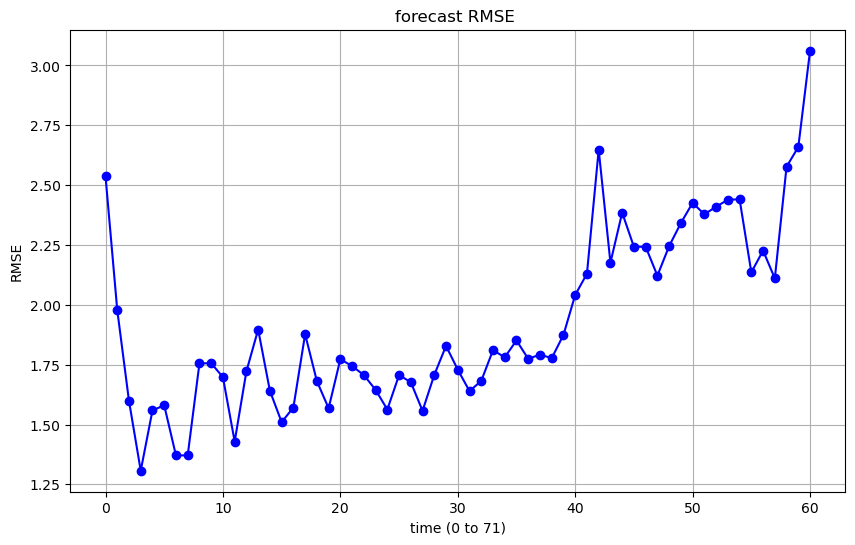

In [56]:
plt.figure(figsize=(10,6))
plt.plot(rmse.index, rmse.values, marker='o', linestyle='-', color='blue')
plt.xlabel('time (0 to 71)')
plt.ylabel('RMSE')
plt.title('forecast RMSE ')
plt.grid(True)
plt.show()

In [ ]:
# 25-06-04 新加入的步骤 存储RMSE 至 csv中
rmse.to_csv('Z:/01TRAINNING_DATA/RMSE/model_forecast_rmse.csv')

分别加载原始预报RMSE以及修订后的RMSE

In [ ]:
df=pd.read_csv('Z:/01TRAINNING_DATA/RMSE/model_forecast_rmse.csv')
df_source=pd.read_csv('Z:/01TRAINNING_DATA/RMSE/source_forecast_rmse.csv')

In [34]:
model_rmse_series=df['0']

In [36]:
source_rmse_series=df_source['0']

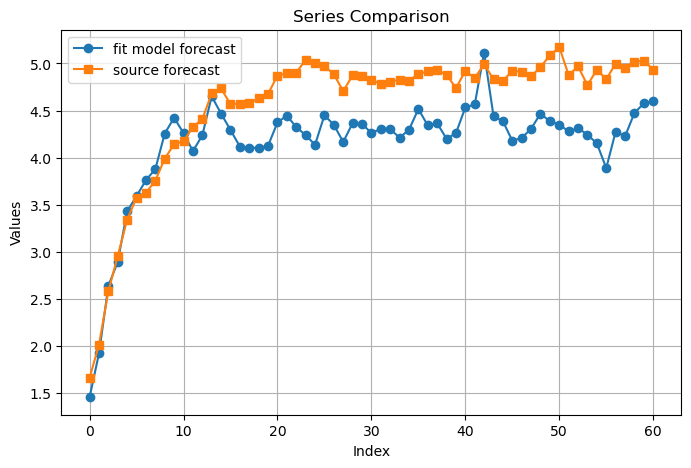

In [37]:
# 创建图表
plt.figure(figsize=(8, 5))  # 设置图像大小
plt.plot(model_rmse_series, label="fit model forecast", marker='o')  # 绘制第一条线
plt.plot(source_rmse_series, label="source forecast", marker='s')  # 绘制第二条线

# 添加标题和标签
plt.title("Series Comparison")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()  # 显示图例
plt.grid()  # 添加网格线

# 显示图表
plt.show()

#### step6: 计算MAE以及偏差

In [53]:
# 计算误差：预测值与实际值的差值
error = df_forecast - df_realdata

# 计算每一列的 MAE
mae_per_column = np.abs(error).mean(axis=1)

# 计算每一列的 Bias
bias_per_column = error.mean(axis=1)

# 如果需要，可以计算所有列 MAE 或 Bias 的均值作为整体指标
overall_mean_mae = mae_per_column.mean()
overall_mean_bias = bias_per_column.mean()


In [54]:
print("每列 MAE:")
print(mae_per_column)
print("所有列 MAE 的均值:", overall_mean_mae)

每列 MAE:
0     1.315412
1     1.537702
2     1.942189
3     2.211387
4     2.532701
        ...   
67         NaN
68         NaN
69         NaN
70         NaN
71         NaN
Length: 72, dtype: float64
所有列 MAE 的均值: 3.563169011107653


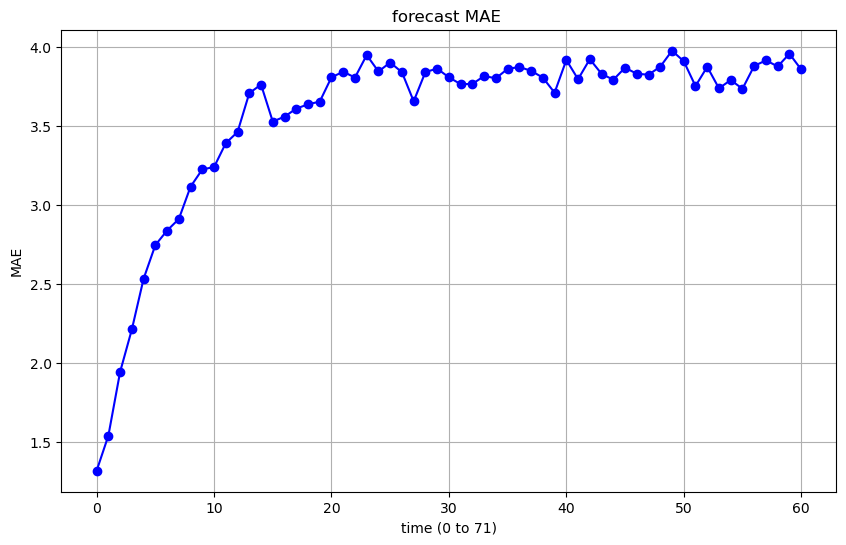

In [57]:
plt.figure(figsize=(10,6))
plt.plot(mae_per_column.index, mae_per_column.values, marker='o', linestyle='-', color='blue')
plt.xlabel('time (0 to 71)')
plt.ylabel('MAE')
plt.title('forecast MAE ')
plt.grid(True)
plt.show()

In [55]:
print("每列 Bias:")
print(bias_per_column)
print("所有列 Bias 的均值:", overall_mean_bias)

每列 Bias:
0     0.146593
1     0.342671
2     0.337135
3     0.275822
4     0.121570
        ...   
67         NaN
68         NaN
69         NaN
70         NaN
71         NaN
Length: 72, dtype: float64
所有列 Bias 的均值: 0.05195199148354405


In [62]:
bias_per_column.tolist()

[0.14659264966415114,
 0.3426706571654673,
 0.33713474385793396,
 0.27582230609579783,
 0.12156985835141215,
 0.345781078136788,
 0.16518114527031563,
 0.017601930309714454,
 0.1898193368307309,
 0.3770846310523737,
 0.10999946217401942,
 -0.035157742915884214,
 -0.030343636474579862,
 0.02311034559527518,
 0.09443327428958836,
 0.007783788297681521,
 -0.07381297327537242,
 0.10440122556408163,
 0.09509527359960761,
 -0.0693672170143733,
 0.07711802994350135,
 0.18728752445909097,
 0.03133371953360634,
 -0.012896527960009549,
 0.04159503966113734,
 0.07489880929872227,
 0.03786629994181996,
 0.07389313593703555,
 -0.028227281877174076,
 0.0762296332708909,
 0.0818671460858398,
 -0.018044130823878568,
 0.19517143543425317,
 0.251730162769702,
 0.061219555256883065,
 -0.021303529543711695,
 -0.02313268269552925,
 -0.026041141999115,
 -0.20593474120029218,
 -0.047000708480532664,
 -0.06762311127037447,
 -0.23155217485422916,
 -0.04347099949054808,
 -0.08553595974710991,
 -0.11521294439711

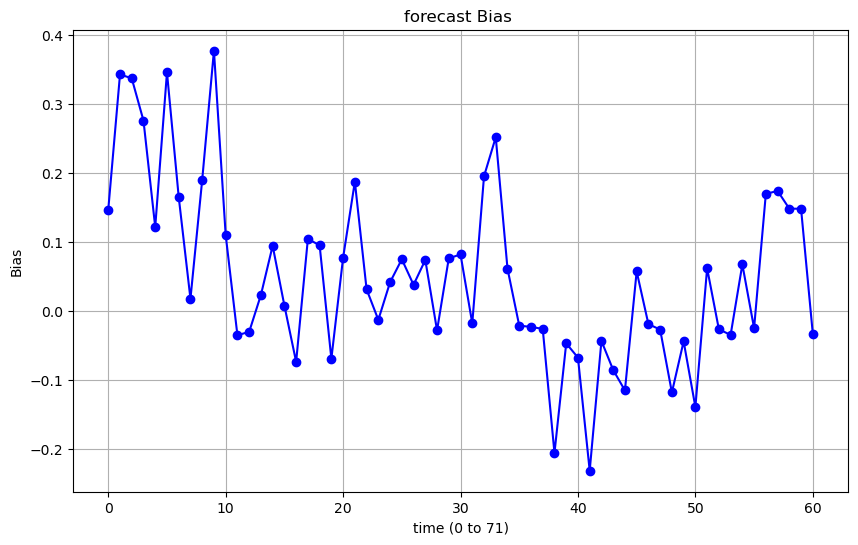

In [60]:
plt.figure(figsize=(10,6))
plt.plot(bias_per_column.index, bias_per_column.values, marker='o', linestyle='-', color='blue')
plt.xlabel('time (0 to 71)')
plt.ylabel('Bias')
plt.title('forecast Bias ')
plt.grid(True)
plt.show()